# Neural networks runthrough
#### by Alvin Zhang
##### Notes and examples based on Bishop's "Pattern Recognition and Machine Learning"

Neural network model: $a_j = \sum_{i=1}^{D}w_{ji}^{(l)}a_i+w_{j0}^{(l)}$ and $z_j = h(a_j)$

## Multilayer Perceptrons

### Maximum likelihood

#### Regression

Suppose we'd like to fit the following sinuisoidal data with Gaussian noise using a neural network.

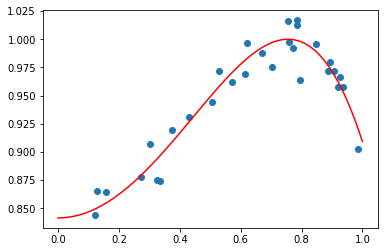

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gen_sin(N=100, s=.03):
    """
    Generate random sinusoidal data.
    Args:
        N (int): number of samples to generate
        s (float): variance of noise
    Returns:
        X (float ndarray): randomly generated x values
        t (float ndarray): sinusoidal target values with Gaussian noise
    """
    X = np.random.rand(N, 1)
    noise = s * np.random.randn(N, 1)
    t = np.sin(1 + X**2) + noise
    return X, t

def plot_sin_data(fig, X=None, t=None):
    """
    Plots sinusoidal data.
    Args:
        fig (figure): figure to plot on
        X (float ndarray): x values to plot
        t (float ndarray): target values to plot
    """
    # Plot points
    if X is not None and t is not None: fig.plot(X, t, 'o')
    # Plot curve
    x_coords = np.arange(0, 1.01, .01)
    y_coords = np.sin(1 + x_coords ** 2)
    fig.plot(x_coords, y_coords, 'r-')

X, t = gen_sin(N=30, s=.015)
plot_sin_data(plt, X, t)
plt.show()

Between each layer, we eventually transform the linear output using a function called the activation function. Since we have a lot of choices for the activation function between layers, we will introduce an activation function utility to help us choose easily.

In [2]:
import numpy as np


def choose_activation(func_name='relu'):
    """
    Activation function chooser.
    Args:
        func_name (string): name of activation function
    Returns:
        (function): activation function
        (function): activation function derivative
    """
    if func_name == 'relu':
        # Leaky relu
        relu = lambda a: (a > 0) * a + (a < 0) * .01 * a
        relu_prime = lambda a: (a > 0) + (a < 0) * .01
        return relu, relu_prime
    if func_name == 'softplus':
        softplus = lambda a: np.log(1+np.exp(a))
        softplus_prime = lambda a: 1/(1+np.exp(-a))
        return softplus, softplus_prime
    if func_name == 'tanh':
        tanh = lambda a: np.tanh(a)
        tanh_prime = lambda a: 1 - np.tanh(a)**2
        return tanh, tanh_prime
    raise ValueError('Invalid activation function name.')


Forward propagation is when we input a data point and run through the neural network to achieve the output. For any layer $l-1$, we have $N$ units (or input, if it's the first layer) $z_1^{(l-1)}, ..., z_N^{(l-1)}, z_0^{(l-1)}$ where $z_0^{(l-1)} = 1$ is the bias term. For each unit in the next layer, we calculate $a_n^{(l)}$ by multiplying each unit in the previous layer by the weight connecting it to $a_n^{(l)}$, and adding the all up. Then for each $a_n^{(l)}$, we apply the activation function to obtain $z_n^{(l)}$. For the last layer, if we are dealing with a classification objective, we apply the sigmoid or softmax. If we're dealing with a regression objective, we don't do anything after calculating all the $a$ for the last layer (i.e. don't apply activation function).

In [3]:
def _fp(X, weights):
    """
    Forward propagates through a neural network.
    Args:
        X (ndarray): input
        weights (ndarray list): all the weights in the neural network model
    Returns:
        a (ndarray list): all the units
        z (ndarray list): all the units with activation function applied 
    """
    N = X.shape[0]
    a, z = [X], [np.hstack((np.ones((N, 1)), X))]
    for layer in weights:
        a.append(z[-1].dot(layer))
        z.append(np.hstack((np.ones((N, 1)), activation_function(a[-1]))))
    if out == 'classification':
        a[-1] = softmax(a[-1]) #softmax
    return a, z

Each $t$ is given by $p(t|\vec{x},\vec{w})=\mathcal{N}(t|y(\vec{x},\vec{w}),\beta^{-1})$, so for a dataset $\mathbf{X}, \mathbf{t}$, the likelihood function is 
$$ p(\mathbf{t}|\vec{x},\vec{w})=\prod_{n=1}^Np(t_n|\vec{x}_n,\vec{w},\beta)$$
The error is given by the negative log likelihood, which is 
$$ \frac{\beta}{2}\sum_{n=1}^N(y(\vec{x}_n,\vec{w})-t_n)^2-\frac{N}{2}\log{\beta}+\frac{N}{2}\log{2\pi}$$
We can get $\vec{w}_{ML}$ by minimization of the error function, and $\beta_{ML}$ is given by $\frac{1}{\beta_{ML}}=\frac{1}{N}\sum_{n=1}^N(y(\vec{x}_n,\vec{w}_ML)-t_n)^2$. <br>
One choice is to directly use numerical optimization to find $\vec{w}_{ML}$. However, this is not practical for huge neural networks. We'd like to find the derivative of the error with respect to the weights so we can use more efficient algorithms. The best method to do this is with backpropagation. After forward propagating and finding all the $a$s and $z$s, we start with the error in the last layer, and backtrack to find all the errors preceding it. <br>
For each unit $a_j^{(l)}$, we have an associated $\delta_j^{(l)}$ where $\delta_j^{(l)}=\frac{\partial E_n}{\partial a_j^{(l)}}=\sum_{k}\frac{\partial E_n}{\partial a_k^{(l+1)}} \frac{\partial a_k^{(l+1)}}{\partial a_j^{(l)}}$. (For the last layer, this is simply just $y_j-t_j$). With $\delta_j^{(l)}$, we can find the derivative with respect to the weights, which is given by $\frac{\partial E_n}{\partial w_{ji}}=\frac{\partial E_n}{\partial a_j^{(l-1)}}\frac{\partial a_j^{(l)}}{\partial w_{ji}}=\delta_j \frac{\partial a_j^{(l)}}{\partial w_{ji}}$. Note that $\frac{\partial a_j^{(l)}}{\partial w_{ji}}$ is just equal to $z_i^{(l-1)}$. We can keep repeating this step to obtain all the derivatives to the weights.

Unfortunately, batch gradient descent is a poor algorithm in using the gradient (although stochastic gradient descent is definitely useful for large datasets); we can resort to more efficient methods such as conjugate gradients and quasi-Newton methods. We have to be careful and run it a few times and choose the best one, since depending on the starting point, the method could converge to a local minima.

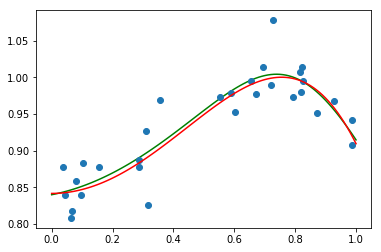

In [4]:
import numpy as np
from scipy.optimize import minimize
#from ActivationUtil import choose_activation


class NN:
    def __init__(self, X, t, num_units, activation_func='softplus', out='regression', K=None):
        """
        Initializes neural network object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values
            num_units (int list): number of units in each layer, including input and excluding bias
            activation_func (string): name of activation function
            out (string): either 'regression' or 'classification'
            K (int): number of classes if out=='classification'
        """
        self.X = X
        self.N, self.D = X.shape
        self.out = out
        if self.out=='classification':
           self.K = K
           t = self._1_of_K(t)
        self.T = t
        self.num_units = num_units  # includes input, excludes bias
        self.num_layers = len(num_units) - 1  # number of weight layers
        self.weights = [0.1*np.random.randn(self.num_units[i]+1, self.num_units[i+1])
                        for i in range(self.num_layers)]
        self.f, self.f_prime = choose_activation(activation_func)

    def _1_of_K(self, t, N=None, K=None):
        """
        Converts a target array to a 1-of-K coding scheme.
        Args:
            t (float ndarray): target values (t:{0, 1,...})
            N (int): number of examples
            K (int): number of classes
        Returns:
            T (float ndarray): target values in 1-of-K scheme
        """
        if N is None: N = self.N
        if K is None: K = self.K
        T = np.zeros((N, K))
        for i in range(N):
            T[i, int(t[i])] = 1
        return T

    def _ravel(self, weights):
        """
        Ravels weights.
        Args:
            weights (ndarray list): list of weights for each layer
        Returns:
            raveled_weights (ndarray): 1D array of all weights
        """
        raveled_weights = np.hstack(weights[i].ravel() for i in range(self.num_layers))
        return raveled_weights

    def _unravel(self, raveled_weights):
        """
        Unravels weights.
        Args:
            raveled_weights (ndarray list): 1D array of all weights
        Returns:
            weights (ndarray list): list of weights for each layer
        """
        slices = np.cumsum([0] + [layer.size for layer in self.weights])
        weights = [raveled_weights[slices[i]:slices[i+1]].reshape(self.weights[i].shape)
                             for i in range(self.num_layers)]
        return weights

    def _softmax(self, a):
        """
        Numerically stable softmax function.
        Args:
            a (float ndarray): input value
        Returns:
            (float ndarray): softmax function applied to all values of a
        """
        m = np.max(a, axis=1).reshape(-1, 1)
        total = np.sum(np.exp(a - m), axis=1).reshape(-1, 1)
        return np.exp(a-m)/total

    def _fp(self, X=None, weights=None):
        """
        Forward propagates through a neural network.
        Args:
            X (ndarray): input
            weights (ndarray list): all the weights in the neural network model
        Returns:
            a (ndarray list): all the units
            z (ndarray list): all the units with activation function applied 
        """
        if X is None: X = self.X
        if weights is None: weights = self.weights

        N = X.shape[0]
        a, z = [X], [np.hstack((np.ones((N, 1)), X))]
        for layer in weights:
            a.append(z[-1].dot(layer))
            z.append(np.hstack((np.ones((N, 1)), self.f(a[-1]))))
        if self.out == 'classification':
            a[-1] = self._softmax(a[-1])
        return a, z

    def _bp(self, X=None, weights=None):
        """
        Back propagates through a neural network.
        Args:
            X (ndarray): input
            weights (ndarray list): all the weights in the neural network model
        Returns:
            weights_grad (ndarray list): gradient of all the weights
            d (ndarray list): delta values for each unit
        """
        if X is None: X = self.X
        if weights is None: weights = self.weights

        a, z = self._fp(X, weights)
        d = [None] * (self.num_layers + 1)
        d[-1] = a[-1] - self.T
        weights_grad = [None] * self.num_layers
        for i in range(self.num_layers-1, -1, -1):
            weights_grad[i] = z[i].T.dot(d[i+1])
            d[i] = d[i+1].dot(weights[i][1:, :].T) * self.f_prime(a[i])
        return weights_grad, d

    def _error(self, X=None, weights=None, lams=None):
        """
        Error function for neural network.
        Args:
            X (ndarray): input
            weights (ndarray list): all the weights in the neural network model
            lams (float list): regularization parameter for each layer
        Returns:
            error (float): error of the neural network
        """
        if X is None: X = self.X
        if weights is None: weights = self.weights

        a, z = self._fp(X, weights)
        if self.out == 'regression':
            error = 0.5 * np.sum((a[-1] - self.T) ** 2, axis=0)[0]
        else:
            a[-1][a[-1] == 0] = 1e-10  # numerical stability
            a[-1][a[-1] == 1] = 1-1e-10  # numerical stability
            error = -np.sum(np.sum(np.log(a[-1][np.where(self.T[:, c] == 1)[0], c]))
                            for c in range(self.K))
        if lams is not None:
            for lam, layer in zip(lams, weights):
                error += lam * np.sum(layer[1:, :] ** 2)
        return error

    def fit(self, lams=None, maxiter=10):
        """
        Finds optimal weights for the neural network.
        Args:
            lams (float list): regularization parameter for each layer
            maxiter (int): maximum number of iterations to run optimization
        Returns:
            weights (ndarray list): optimal weights
        """
        def f(W):
            weights = self._unravel(W)
            return self._error(self.X, weights, lams=lams)

        def f_prime(W):
            weights = self._unravel(W)
            ans = self._bp(self.X, weights)[0]
            return self._ravel(ans)

        min_error = float('inf')
        for _ in range(maxiter):
            W_rand = self._ravel([np.random.randn(self.num_units[i]+1, self.num_units[i+1])
                                  for i in range(self.num_layers)])
            res = minimize(f, W_rand, method='CG', jac=f_prime)
            if res.fun < min_error:
                self.weights = self._unravel(res.x)
                min_error = res.fun
        return self.weights

    def pred(self, x):
        """
        Predicts output of the neural network.
        Args:
            x (ndarray): input value to predict
        Returns:
            (float): target if regression, class and associated value if classification
        """
        a, z = self._fp(x, self.weights)
        if self.out == 'regression':
            return a[-1]
        else:
            pred, val = np.argmax(a[-1]), np.max(a[-1])
            return pred, val

    def _grad_check(self, eps=0.001):
        """
        Gradient checking for back propagation.
        Args:
            eps (float): perturbation value
        Returns:
            weights_grad (ndarray list): appxomiate gradient for weights
        """
        raveled = self._ravel(self.weights)
        weights_grad = []
        for i in range(len(raveled)):
            raveled[i] += eps
            error1 = self._error(self._unravel(raveled))
            raveled[i] -= 2*eps
            error2 = self._error(self._unravel(raveled))
            raveled[i] += eps
            weights_grad.append((error1-error2)/(2*eps))
        weights_grad = self._unravel(weights_grad)
        return weights_grad

X, t = gen_sin(30, .03)
reg = NN(X, t, [1, 3, 1], activation_func='softplus', out='regression')
reg.fit()

x_coords = np.arange(0, 1.01, .01)
y_coords = reg.pred(x_coords.reshape(-1, 1))
plt.plot(x_coords, y_coords, 'g-')
plot_sin_data(plt, X, t)
plt.show()

#### Classification

Suppose we'd like to classify the following complex data with two classes 

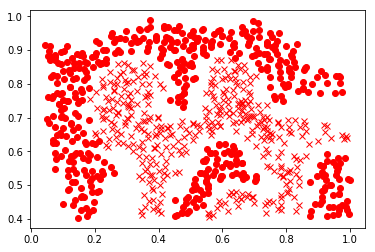

In [5]:
def plot_c_data(fig, X, t):
    """
    Plots classification data.
    Args:
        fig (figure): figure to plot on
        X (float ndarray): x values to plot
        t (float ndarray): corresponding classes to X
    """
    markers = ['rx', 'ro', 'r+', 'r^', 'r.']
    for i, c in enumerate(np.unique(t)):
        fig.plot(X[np.where(t==c)[0], [0]], X[np.where(t==c)[0], [1]], markers[i])

def plot_contour(fig, x_coords, y_coords, clas, grad=True, levels=100):
    """
    Plots contours for classification data.
    Args:
        fig (figure): figure to plot on
        x_coords (float iterable): x coordinate range
        y_coords (float iterable): y coordinate range
        clas (classifier): classifier object with 'pred' function
    """
    X_coords, Y_coords = np.meshgrid(x_coords, y_coords)
    Z_coords = np.zeros(X_coords.shape)
    for i in range(X_coords.shape[0]):
        for j in range(X_coords.shape[1]):
            x = np.asarray([[X_coords[i, j], Y_coords[i, j]]])
            Z_coords[i, j] = clas.pred(x)[grad]
    fig.contourf(X_coords, Y_coords, Z_coords, levels)

file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set3X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set3t.csv'

X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

x_coords = np.arange(0, 1.3, 0.1)
y_coords = np.arange(.3, 1.3, 0.1)

plot_c_data(plt, X, t)
plt.show()

We'll use a three layer neural network with 4 weights in each of the two hidden layers. Since this is classification, the error is given by the cross-entropy error, which is 
$$E(\vec{w})=-\sum_{n=1}^N(t_n\log{y_n}+(1-t_n)\log{(1-y_n)})$$ for two classes. Multiclass is generalized using the softmax function so that $y_k(\vec{x},\vec{w})=\frac{e^{a_k(\vec{x},\vec{w})}}{\sum_je^{a_j(\vec{x},\vec{w})}}$. The error function is then given by $$E(\vec{w})=-\sum_{n=1}^N\sum_{k=1}^Kt_{nk}\log{y_k(\vec{x}_n,\vec{w})}$$
We'll use the tanh function as the activation, and use backpropagation and conjugate gradients.

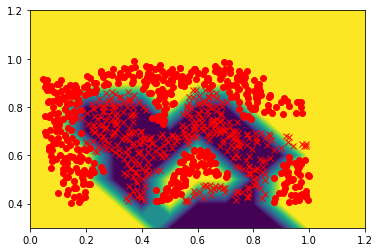

In [39]:
clas = NN(X, t, [2, 4, 4, 2], activation_func='tanh', out='classification', K=2)
clas.fit()

plot_c_data(plt, X, t)
plot_contour(plt, x_coords, y_coords, clas, grad=False, levels=100)
plt.show()

### Bayesian

Because Bayesian neural networks are just maximum likelihood neural networks with regularization, we'll forgo implementing these for now. I'll definitely implement them later when I have time.

#### Regression

Suppose we'd like to view neural networks from a Bayesian perspective. We introduce a prior for the weight parameters as 
$$ p(\vec{w}|\alpha)=\mathcal{N}(\vec{w}|\vec{0},\alpha^{-1}\mathbf{I})$$
where $\alpha^{-1}$ is a hyperparameter.<br>
With a datapoint $\{\vec{x}, t\}$, we have $p(t|\vec{x},\vec{w},\beta) = \mathcal(t|y(\vec{x},\vec{w}),\beta^{-1})$ where $\beta^{-1}$ is also a hyperparameter. With a dataset $D=\{t_1,...,t_N\}$ and observations $\vec{x}_1,...,\vec{x}_N$, we have the likelihood function
$$ p(D|\vec{w},\beta)=\prod_{n=1}^N\mathcal{N}(t_n|y(\vec{x}_n,\vec{w}), \beta^{-1}) $$
The posterior is proportional to the product of the prior and likliehood, and is obviously non-Gaussian because $y$ is non-linear. We can use the Laplace approximation to find a Gaussian approximation, though we first have to find $\vec{w}_{MAP}$ via maximizing
$$\log{p(\vec{x}|D)}=-\frac{\alpha}{2}\vec{w}^T\vec{w}-\frac{\beta}{2}\sum_{n=1}^N(y(\vec{x}_n,\vec{w})-t_n)^2 + \text{const}$$
We then have the approximation $q(\vec{w}|D)=\mathcal{N}(\vec{w}|\vec{w}_{MAP},\mathbf{A}^{-1})$ where $\mathbf{A}=-\nabla\nabla\log{p(\vec{w}|D,\alpha,\beta)}=\alpha\mathbf{I}+\beta\mathbf{H}$ where $\mathbf{H}$ is the Hessian. <br>
To approximate the predictive distribution ($p(t|\vec{x},D)=\int p(t|\vec{x},\vec{w})q(\vec{w}|D)d\vec{w}$), we have to assume that $y$ is approximately linear w.r.t. the parameters in the space where the posterior is significantly nonzero so that we can take Taylor series and drop nonlinear terms. We have
$$y(\vec{x},\vec{w})\simeq y(\vec{x},\vec{w}_{MAP})+\vec{g}^T(\vec{w}-\vec{w}_{MAP})$$ where $\vec{g}=\nabla_{\vec{w}}y(\vec{x},\vec{w})|_{\vec{w}=\vec{w}_{MAP}}$. We can now approximate $p(t|\vec{x},\vec{w},\beta)$ as $\mathcal{N}(t|y(\vec{x},\vec{w}_{MAP})+\vec{g}^T(\vec{w}-\vec{w}_{MAP}),\beta^{-1})$ so that
$$p(t|\vec{x},D,\alpha,\beta)=\mathcal{N}(t|y(\vec{x},\vec{w}_{MAP}),\sigma^2(\vec{x}))$$
where $\sigma^2(\vec{x})=\beta^{-1}+\vec{g}^T\mathbf{A}^{-1}\vec{g}$. <br>
Note that we can also optimize the hyperparameters in the same way as we did in Bayesian linear regression.

#### Classification

We'll consider the case for two classes, since generalization to multiple classes is straightforward and mostly just replacing sigmoid with softmax. The log likelihood is given by
$$\log{p(D|\vec{w})}=\sum_{n=1}^N(t_n\log{y_n}+(1-t_n)\log(1-y_n))$$
and the prior is given by
$$p(\vec{w}|\alpha)=\mathcal{N}(\vec{w}|\vec{0},\alpha^{-1}\mathbf{I})$$
Our objective is to minimize $E(\vec{w})=-\log{p(D|\vec{w})}+\frac{\alpha}{2}\vec{w}^T\vec{w}$ after initializing $\alpha$ in order to find $\vec{w}_{MAP}$. We can then optimize $\alpha$ by maximizing the mariginal likelihood
$$\log{p(D|\alpha)}\simeq-E(\vec{w}_{MAP})-\frac{1}{2}\log{|\mathbf{A}|}+\frac{W}{2}\log{\alpha}$$ where $W$ is the total number of parameters and $E(\vec{w}_{MAP})=-\sum_{n=1}^N(t_n\log{y_n}+(1-t_n)\log{(1-y_n)})+\frac{\alpha}{2}\vec{w}_{MAP}^T\vec{w}_{MAP}$ and $\mathbf{A}=\alpha\mathbf{I}$. We therefore have 
$$\alpha=\frac{\gamma}{\vec{w}_{MAP}^T\vec{w}_{MAP}}$$ where $\gamma=\sum_{i=1}^W\frac{\lambda_i}{\alpha+\lambda_i}$. <br>
The predictive distribution is found by linearly approximating the output unit and taking account of the variance of the posterior so that
$a(\vec{x},\vec{w})\simeq a(\vec{x},\vec{w}_{MAP})+b^T(\vec{w}-\vec{w}_{MAP})$ where $b=\nabla a(\vec{x},\vec{w}_{MAP})$ founod by backprop. We then have $$p(a|\vec{x},D)=\int \delta(a-a(\vec{x},\vec{w}_{MAP})-\vec{b}^T(\vec{x})(\vec{w}-\vec{w}_{MAP}))q(\vec{w}|D)d\vec{w}$$
$$\Rightarrow p(a|\vec{x}|D)=\mathcal{N}(a|a(\vec{x},\vec{w}_{MAP}),\sigma^2_a(\vec{x}))$$
where $q(\vec{w}|D)=\mathcal{N}(\vec{w}|\vec{w}_{MAP},\mathbf{A}^{-1})$ and $\mathbf{A}=-\nabla\log{p(\vec{w}|D,\alpha)}=\alpha\mathbf{I}$ and $\sigma^2_a(\vec{x})=\vec{b}^T(\vec{x})\mathbf{A}^{-1}\vec{b}(\vec{x})$. <br>
We can finally reference section 4.5.2 to obtain
$$p(t=1|\vec{x},D)=\int \sigma(a)p(a|\vec{x},D)da\simeq\sigma(\kappa(\sigma_a^2)a(\vec{x},\vec{w}_{MAP}))$$
where $\kappa(\sigma_a^2)=(1+\frac{\pi}{8}\sigma^2_a)^{-\frac{1}{2}}$.

## Convolutional NNs

Convolutional neural networks are able to build invariance properties into the structure of a neural network. This is especially useful for image classification; for example, the neural network should recognize a handwritten '3' regardsless of size or small rotation. The three mechanisms involved in convnets are local receptive fields, weight sharing, and subsampling. An example architecture (LeNet5) is shown below.
<img src='https://www.researchgate.net/profile/Haohan_Wang/publication/282997080/figure/fig10/AS:305939199610894@1449952997905/Figure-10-Architecture-of-LeNet-5-one-of-the-first-initial-architectures-of-CNN.png'> <br>
In the convolution step, a kernel is slid across the entire image and eventually produces a feature map, which we apply an activation function to. We then make the feature map smaller by subsampling -- either max-pooling (where we choose the largest value out of, say, each 2x2 block) or average-pooling (where we average all the values in the block). We can do this many times, and include fully connected layers where we'd like to. <br>
<img src='https://i.imgur.com/dWgVCO8.png'>
Backpropagation is the same concept but more complicated, since we are weight sharing. <br>
To backpropagate delta through a pooling layer, we assign the delta to the maximum value for max-pool or average the delta for each block for average-pooling. 
<img src='https://i.imgur.com/VVZD6aC.png' height="120" width="480">
To backpropagate delta through a convolution, we have to zero-pad the delta, flip the connecting kernel, and then convolute. If we observe the first image, notice that this process will get the gradients with respect to the kernel. (e.g. the green block = 1a+2b+5c+6d, when we convolute the flipped kernel on the padded delta, the delta is only multiplied by a, since '1' was multiplied by a originally)
<img src='https://i.imgur.com/itvEw5B.png' height="120" width="360">
To find the gradient of the error w.r.t. the kernels, we can convolute the previous layer with the delta from the next layer. (e.g. in the example above, notice that the coefficients of a are {1, 2, 3, 5, 6, 7, 9, 10, 11}. Convoluting the 4x4 first image using the 3x3 delta will result in the kernel gradients) 
<img src='https://i.imgur.com/NVVGez8.png' height="120" width="360">

In [ ]:
import numpy as np
from scipy import optimize
from ActivationUtil import choose_activation

class CNN:
    def __init__(self, X, t, num_kernels, kernel_dims=None, pool_dims=None, pool_type='max', activation_func='softplus'):
        """
        Initializes convolutional neural network object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values
            num_kernels (int list): number of kernels in each layer
            kernel_dims (int list list): kernel dimensions for each layer
            pool_dims (int list list): pooling dimensions for each layer
            activation_func (string): activation function name
        """
        self.X = X
        self.t = t
        self.num_inputs = X.shape[0]
        self.num_layers = len(num_kernels)
        self.num_kernels = num_kernels
        if kernel_dims is None: kernel_dims = [[5, 5]] * self.num_layers
        self.kernel_dims = kernel_dims
        self.kernels, self.bs = [], []
        for layer in range(self.num_layers):
            self.kernels.append([0.1*np.random.randn(*kernel_dims[layer])
                                 for _ in range(num_kernels[layer])])
            self.bs.append(np.asarray([0.1*np.random.randn()
                           for _ in range(num_kernels[layer])]).reshape(-1, 1))
        if pool_dims is None: pool_dims = [[2, 2]] * self.num_layers
        self.pool_dims = pool_dims
        self.pool_type = pool_type
        self.f, self.f_prime = choose_activation(activation_func)

    def _convolve(self, arr, kernel):
        """
        Convolutes an array with a kernel.
        Args:
            arr (float ndarray): array to be convoluted
            kernel (float ndarray): kernel for array to be convoluted with
        Returns:
            conv (float ndarray): convoluted array
        """
        arr_nrows, arr_ncols = arr.shape
        kernel_nrows, kernel_ncols = kernel.shape
        conv = np.zeros((arr_nrows-kernel_nrows+1, arr_ncols-kernel_ncols+1))
        for i in range(conv.shape[0]):
            for j in range(conv.shape[1]):
                conv[i, j] = np.sum(arr[i:i+kernel_nrows, j:j+kernel_ncols] * kernel)
        return conv

    def _flip(self, arr):
        """
        Flips an array (eq to rotating 180 degrees)
        Args:
            arr (float ndarray): array to be flipped
        Returns:
            (float ndarray): flipped array
        """
        return np.flip(np.flip(arr, axis=0), axis=1)

    def _ravel(self, kernels, bs):
        """
        Ravels kernels and bias terms.
        Args:
            kernels (ndarray list list): kernels for each layer
            bs (float list): biases for each layer
        Returns:
            (ndarray): 1D array of all kernels and biases
        """
        raveled_kernels = np.hstack(kernels[i][j].ravel() for i in range(self.num_layers)
                                                          for j in range(self.num_kernels[i]))
        raveled_bs = np.hstack(bs[i].ravel() for i in range(self.num_layers))
        return np.hstack((raveled_kernels, raveled_bs))

    def _unravel(self, raveled_combined):
        """
        Unravels kernels and bias terms.
        Args:
            raveled_combined (ndarray): 1D array of all kernels and biases
        Returns:
            unraveled_kernels (ndarray list list): kernels for each layer
            unraveled_bs (float list): biases for each layer
        """
        kernels, bs = [], []
        for i in range(self.num_layers):
            curr_size = int(np.sum([self.num_kernels[j] * (self.kernel_dims[j][0] * self.kernel_dims[j][1]) for j in range(i)]))
            size = self.kernel_dims[i][0] * self.kernel_dims[i][1]
            kernels.append([raveled_combined[curr_size+j*size:curr_size+(j+1)*size].reshape(self.kernel_dims[i])
                                     for j in range(self.num_kernels[i])])
        for i in range(self.num_layers):
            curr_size = int(
                np.sum([self.num_kernels[j] * (self.kernel_dims[j][0] * self.kernel_dims[j][1]) for j in
                        range(self.num_layers)])) + int(np.sum([self.num_kernels[j] for j in range(i)]))
            bs.append(raveled_combined[curr_size:curr_size+self.num_kernels[i]])
        return kernels, bs

    def _pool(self, arr, dims, option='max'):
        """
        Max-pools or average-pools an array.
        Args:
            arr (ndarray): array to be pooled
            dims (int list): dimensions to pool with
        Returns:
            pooled (ndarray): pooled array
        """
        option = self.pool_type
        arr_nrows, arr_ncols = arr.shape
        pooled = np.zeros((arr_nrows//dims[0], arr_ncols//dims[1]))
        for i in range(pooled.shape[0]):
            for j in range(pooled.shape[1]):
                if option == 'max':
                    pooled[i, j] = np.max(arr[dims[0]*i:dims[0]*(i+1),
                                          dims[1]*j:dims[1]*(j+1)])
                else:  # average
                    pooled[i, j] = np.average(arr[dims[0]*i:dims[0]*(i+1),
                                              dims[1]*j:dims[1]*(j+1)])
        return pooled

    def _unpool(self, z, d, option='max'):
        """
        Unpools an array.
        Args:
            z (ndarray): original unpooled array
            d (ndarray): pooled array
        Returns:
            unpooled (ndarray): if max-pooled, assign values in d to indices maximum in z and zeros elsewhere
                                if average-pooled, assign average d to corresponding block 
        """
        dims = [z.shape[0]//d.shape[0], z.shape[1]//d.shape[1]]
        unpooled = np.zeros(z.shape)
        for i in range(d.shape[0]):
            for j in range(d.shape[1]):
                if option == 'max':
                    index = list(np.unravel_index(np.argmax(z[dims[0]*i:dims[0]*(i+1),
                                                  dims[1]*j:dims[1]*(j+1)]), dims))
                    index[0] += dims[0]*i
                    index[1] += dims[1]*j
                    unpooled[index[0], index[1]] = d[i, j]
                else:  # average
                    unpooled[dims[0]*i:dims[0]*(i+1),
                             dims[1]*j:dims[1]*(j+1)] = 1/(dims[0]*dims[1]) * d[i, j]
        return unpooled

    def _pad(self, arr, n):
        """
        Pads an array with zeros.
        Args:
            arr (ndarray): array to pad
            n (ndarray): number of zeros to pad (each side)
        Returns:
            padded (ndarray): zero-padded array
        """
        padded = np.hstack((np.zeros((arr.shape[0], n)), arr, np.zeros((arr.shape[0], n))))
        padded = np.vstack((np.zeros((n, padded.shape[1])), padded, np.zeros((n, padded.shape[1]))))
        return padded

    def _fp(self, X=None, kernels=None, bs=None):
        """
        Forward propagates through a convnet.
        Args:
            X (ndarray): input
            kernels (ndarray list list): all the kernels in the convnet model
            bs (float list): all the biases in the convnet model
        Returns:
            p (ndarray list list): all the pooled feature maps
            a (ndarray list list): all the feature maps
            z (ndarray list list): all the feature maps with activation function applied 
        """
        if X is None: X = self.X
        if kernels is None: kernels = self.kernels
        if bs is None: bs = self.bs
        p, a, z = [[X]], [[X]], [[X]]
        for i in range(self.num_layers):
            p.append([])
            a.append([])
            z.append([])
            for kernel, b in zip(kernels[i], bs[i]):
                a[-1].append(sum(np.asarray([self._convolve(s, kernel) + b for s in p[-2][i]])
                                        for i in range(len(p[-2]))))
                z[-1].append(np.asarray([self.f(s) for s in a[-1][-1]]))
                p[-1].append(np.asarray([self._pool(s, self.pool_dims[i]) for s in z[-1][-1]]))
        return p, a, z

    def _bp(self, X=None, kernels=None, bs=None, delta=None):
         """
        Back propagates through a convnet.
        Args:
            X (ndarray): input
            kernels (ndarray list list): all the kernels in the convnet model
            bs (float list): all the biases in the convnet model
            delta (ndarray list): final layer delta values
        Returns:
            kernel_grads (ndarray list list): gradient of all the kernels
            b_grads (float list): gradient of all the biases
            d (ndarray list list): delta values for layer
        """
        if X is None: X = self.X
        if kernels is None: kernels = self.kernels
        if bs is None: bs = self.bs

        d = [None] * (self.num_layers + 1)
        kernel_grads = [None] * self.num_layers
        b_grads = [None] * self.num_layers
        p, a, z = self._fp(X, kernels, bs)
        if delta is None:
            delta = [p[-1][k] - self.t[k] for k in range(len(self.t))]
        d[-1] = delta

        for i in range(self.num_layers, 0, -1):
            kernel_grads[i-1] = []
            d[i] = [np.asarray([self._unpool(z[i][k][n], d[i][k][n]) * self.f_prime(a[i][k][n])
                                for n in range(self.num_inputs)])
                    for k in range(len(d[i]))]
            b_grads[i-1] = np.asarray([len(p[i-1])*np.sum(d[i][k]) for k in range(len(d[i]))])
            for j in range(len(d[i])):
                kernel_grads[i-1].append(sum(sum(self._convolve(p[i-1][k][n], d[i][j][n])
                                                 for n in range(p[i-1][k].shape[0]))
                                             for k in range(len(p[i-1]))))
            d_padded = [np.asarray([self._pad(d[i][j][n], self.kernel_dims[i-1][0]-1)
                                    for n in range(len(d[i][j]))])
                        for j in range(len(d[i]))]
            d[i-1] = []
            for j in range(len(p[i-1])):
                d[i-1].append(np.asarray([sum(self._convolve(d_padded[k][n], self._flip(self.kernels[i-1][k]))
                                              for k in range(len(d_padded)))
                                          for n in range(self.num_inputs)]))
        return kernel_grads, b_grads, d

    def _error(self, kernels, bs):
        """
        Error function for neural network.
        Args:
            kernels (ndarray list list): all the kernels in the convnet model
            bs (float list): all the biases in the convnet model
        Returns:
            error (float): error of the convnet
        """
        p, a, z = self._fp(self.X, kernels, bs)
        error = 0.5 * np.sum(np.asarray([self.t[i] - p[-1][i] for i in range(len(self.t))])**2)
        return error

    def _grad_check(self, eps=1e-4):
        """
        Gradient checking for back propagation.
        Args:
            eps (float): perturbation value
        Returns:
            kernel_grads (ndarray list list): appxomiate gradient for kernels
            b_grads (float list): approximate gradient for biases
        """
        raveled_combined = self._ravel(self.kernels, self.bs)

        grads = []
        for i in range(len(raveled_combined)):
            raveled_combined[i] += eps
            error1 = self._error(self._unravel(raveled_combined))
            raveled_combined[i] -= 2*eps
            error2 = self._error(self._unravel(raveled_combined))
            grads.append((error1-error2)/(2*eps))
            raveled_combined[i] += eps
        kernel_grads, b_grads = self._unravel(np.asarray(grads))
        return kernel_grads, b_grads


Note that the class above contains only convnet layers. However, it's easy to connect convnet layers with fully connected layers. We'll model the LeNet5 architecture shown above by connecting the CNN class with a NN class.

In [42]:
import numpy as np
from scipy import optimize
from collections import deque
from nn import NN
from cnn import CNN

class LeNet:
    def __init__(self, X, t):
        """
        Initializes LeNet architecture object
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values
        """
        self.X = X
        self.num_inputs = X.shape[0]
        self.cnn = CNN(X, None, [6, 12], 
                     kernel_dims=[[5, 5], [5, 5]],
                     pool_dims=[[2, 2], [2, 2]],
                     activation_func='leaky')
        self.nn = NN(np.asarray([[None]]), t, [192, 48, 30, 10],
                     activation_func='leaky',
                     out='classification', K=10)
        self.num_params = self.cnn.num_params + self.nn.num_params
        # Re-initialize weights
        for layer in range(self.cnn.num_layers):
            for k in range(self.cnn.num_kernels[layer]):
                self.cnn.kernels[layer][k] *= np.sqrt(self.cnn.num_params/self.num_params)
        for layer in range(self.nn.num_layers):
            self.nn.weights[layer][1:, :] *= np.sqrt(self.nn.num_params/self.num_params)
        self.T = self.nn._1_of_K(t, N=self.num_inputs, K=10)

    def _ravel(self, kernels, bs, weights):
        """
        Ravels kernels, bias terms, and weights.
        Args:
            kernels (ndarray list list): kernels for each layer
            bs (float list): biases for each layer
            weights (ndarray list): weights for each layer
        Returns:
            (ndarray): 1D array of all kernels, biases, and weights
        """
        raveled_kernels_bs = self.cnn._ravel(kernels, bs)
        raveled_weights = self.nn._ravel(weights)
        return np.hstack((raveled_kernels_bs, raveled_weights))

    def _unravel(self, raveled):
        """
        Unravels kernels and bias terms.
        Args:
            raveled (ndarray): 1D array of all kernels and biases
        Returns:
            kernels (ndarray list list): kernels for each layer
            bs (float list): biases for each layer
            weights (ndarray list): weights for each layer
        """
        index = sum([n*dim[0]*dim[1] for n, dim in zip(self.cnn.num_kernels, self.cnn.kernel_dims)])
        index += sum(self.cnn.num_kernels)
        kernels, bs = self.cnn._unravel(raveled[:index])
        weights = self.nn._unravel(raveled[index:])
        return kernels, bs, weights

    def _error(self, X, kernels, bs, weights):
        """
        Error function for entire model.
        Args:
            X (ndarray): input value
            kernels (ndarray list list): kernels for each layer
            bs (float list): biases for each layer
            weights (ndarray list): weights for each layer
        Returns:
            error (float): error of the model
        """
        p = self.cnn._fp(X, kernels=kernels, bs=bs)[0][-1]
        X_nn = np.asarray([np.hstack(p[i][n].ravel() for i in range(len(p)))
                           for n in range(self.num_inputs)])
        return self.nn._error(X_nn, weights)

    def _error_grad(self, X, kernels, bs, weights):
        """
        Gradient of error for entire model.
        Args:
            X (ndarray): input value
            kernels (ndarray list list): kernels for each layer
            bs (float list): biases for each layer
            weights (ndarray list): weights for each layer
        Returns:
            kernel_grads (ndarray list list): kernel gradient
            b_grads (float list): bias gradient
            weights_grad (ndarray list): weights gradient
        """
        p = self.cnn._fp(X, kernels, bs)[0][-1]
        X_nn = np.asarray([np.hstack(p[i][n].ravel() 
                                     for i in range(len(p)))
                           for n in range(self.num_inputs)])
        weights_grad, d = self.nn._bp(X_nn, weights)
        d = d[0]
        size = d.shape[1] // self.cnn.num_kernels[-1]
        _, dim1, dim2 = p[0].shape
        delta = [d[:, size*i:size*(i+1)].ravel() for i in range(self.cnn.num_kernels[-1])]
        delta = [delta[i].reshape(self.num_inputs, dim1, dim2) for i in range(self.cnn.num_kernels[-1])]

        kernel_grads, b_grads, d = self.cnn._bp(X, kernels, bs, delta)
        return kernel_grads, b_grads, weights_grad

    def _grad_check(self, eps=0.001):
        """
        Gradient checking for error function.
        Args:
            eps (float): perturbation value
        Returns:
            kernel_grads (ndarray list list): appxomiate gradient for kernels
            b_grads (float list): approximate gradient for biases
            weights_grad (float list): approximate gradient for weights
        """
        raveled = self._ravel(self.cnn.kernels, self.cnn.bs, self.nn.weights)
        grads = []
        for i in range(len(raveled)):
            raveled[i] += eps
            error1 = self._error(self._unravel(raveled))
            raveled[i] -= 2*eps
            error2 = self._error(self._unravel(raveled))
            grads.append((error1-error2)/(2*eps))
            raveled[i] += eps
        return self._unravel(np.asarray(grads))

    def fit(self, lp=1e-2, lam=0, disp='True'):
        """
        Fits model.
        Args:
            lp (float): learning parameter
            lam (float): regularization coefficient (L2)
            disp (bool): whether to print stats or not
        """
        counter, total_err = 0, 0
        errs = deque()
        eps = 1e-8
        cache = np.zeros((self.num_params))

        for i in np.random.permutation(self.X.shape[0]):
            self.num_inputs = 1
            self.cnn.num_inputs = 1
            self.nn.T = self.T[i].reshape(1, -1)

            x = ((self.X[i]-128)/128).reshape(1, 28, 28)
            t = np.argmax(self.T[i])

            # Print stats
            if disp:
                err = self._error(x, self.cnn.kernels, self.cnn.bs, self.nn.weights)
                errs.append(err)
                total_err += err
                if counter > 100: total_err -= errs.popleft()
                counter += 1
                print(counter, '******', '{0:.2f}'.format(err), '{0:.2f}'.format(total_err/min(counter, 100)))

            kernel_grads, b_grads, weights_grad = \
                self._error_grad(x,  self.cnn.kernels, self.cnn.bs, self.nn.weights)
            # Regularize
            for layer in range(self.cnn.num_layers):
                for k in range(self.cnn.num_kernels[layer]):
                    kernel_grads[layer][k] += lam * self.cnn.kernels[layer][k]
            for layer in range(self.nn.num_layers):
                weights_grad[layer][1:, :] += lam * self.nn.weights[layer][1:, :]
            # Update
            curr = self._ravel(self.cnn.kernels, self.cnn.bs, self.nn.weights)
            grads = self._ravel(kernel_grads, b_grads, weights_grad)
            cache += grads**2
            curr += (-lp * grads)/(np.sqrt(cache) + eps)

            self.cnn.kernels, self.cnn.bs, self.nn.weights = self._unravel(curr)
                
    def pred(self, x):
        """
        Predicts output of model.
        Args:
            x (ndarray): input value to predict
        Returns:
            (float ndarray): target
        """
        kernels, bs = self.cnn.kernels, self.cnn.bs
        p = self.cnn._fp(x, kernels, bs)[0][-1]
        x_nn = np.asarray([np.hstack(p[i][n].ravel()
                                     for i in range(len(p)))
                           for n in range(self.num_inputs)])
        return self.nn.pred(x_nn)

file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\mnist_X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\mnist_t.csv'

X = np.loadtxt(file_name_X, delimiter=',')
X = X.reshape(X.shape[0], 28, 28)
t = np.loadtxt(file_name_t, delimiter=',')
params = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\parameters.txt'

test = LeNet(X, t)
test.cnn.kernels, test.cnn.bs, test.nn.weights = test._unravel(np.loadtxt(params))
test.fit()
np.savetxt(params, test._ravel(test.cnn.kernels, test.cnn.bs, test.nn.weights))


Some notes: when fitting, we don't use vanilla stochastic gradient descent. This implementation uses AdaGrad, a special method that converges better. We also initialize weights to $\sqrt{\frac{2}{n}}$ where $n$ is the number of parameters. Doing this also result in a better convergence rate. Source: http://cs231n.github.io/neural-networks-3/. Lastly, we also use L2 regularization with a uniform regularization parameter. <br>
After training the above data for 10 epochs, we end up with a roughly 85% accuracy on the MNIST test dataset. This is a very inefficient model (took like 60 hours to train lol), so we should resort to much more optimized frameworks. In the example below, we use TensorFlow for efficient training. <br><br>The following code is from https://www.tensorflow.org/tutorials/layers, with slight modifications for a LeNet5 architecture.

In [7]:
import tensorflow as tf
import numpy as np

def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=6,
      kernel_size=[5, 5],
      padding="valid",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=12,
      kernel_size=[5, 5],
      padding="valid",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer #1
    pool2_flat = tf.reshape(pool2, [-1, 192])
    dense1 = tf.layers.dense(inputs=pool2_flat, units=48, activation=tf.nn.relu)

    # Dense Layer #2
    pool2_flat = tf.reshape(pool2, [-1, 48])
    dense2 = tf.layers.dense(inputs=dense1, units=30, activation=tf.nn.relu)

    # Logits Layer
    logits = tf.layers.dense(inputs=dense2, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
      onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

train_data = np.loadtxt('C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\mnist_X.csv',
                        delimiter=',',
                        dtype=np.float32)
train_labels = np.loadtxt('C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\mnist_t.csv',
                          delimiter=',',
                          dtype=np.int32)
eval_data = np.loadtxt('C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\mnist_test_X.csv',
                       delimiter=',',
                       dtype=np.float32)
eval_labels = np.loadtxt('C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\mnist_test_t.csv',
                         delimiter=',',
                         dtype=np.int32)

tf.logging.set_verbosity(tf.logging.ERROR)

mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\Neural Networks")

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=100,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000)

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

{'accuracy': 0.97570002, 'loss': 0.081972614, 'global_step': 20000}


After only ~20 minutes of training (100 epochs), this model already does better than our previous model.

TODO: Implement Bayesian NNs, Hessian/Jacobian calculations, Mixture density networks, Recurrent NNs, make CNN more efficient